# A/B Testing on Mobile Game Data

The data is taken from a mobile game called Cookie Cat. It represnts players progress throughout the game in which they encounter obstacles represented as gates that players have to cross either by waiting or doing in-app purchases. In this project we conduct an A/B test to study players retention rate if the first gate in the game is moved from level 30 to level 40. 

## Load Packages

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## Load dataset

In [2]:

data=pd.read_csv('cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Inspect data

In [30]:
# Missing values in dataset
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

There is nothing better then a dataset having no missing values.

In [9]:
#Number of Unique Values
data.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

The columns version, retention_1 and retention_2 are represented as factors of two levels each.

In [6]:
# Overall Summary 
data.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

This clearly shows that there are abnormal values in the sum_gamerounds column.

In [10]:
# Summary based on Versions
data.groupby('version').sum_gamerounds.agg(['count','median','min','max','mean','std'])

,count,median,min,max,mean,std
version,,,,,,
gate_30,44700,17,0,49854,52.456264,256.716423
gate_40,45489,16,0,2640,51.298776,103.294416


## Removing abnormal values

Text(0.5, 1.0, 'Boxplot of gate_30 and gate_40 versions')

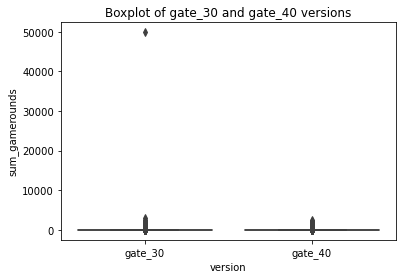

In [19]:
# Making boxplot of both versions.
sns.boxplot(x='version',y='sum_gamerounds',data=data)
plt.title('Boxplot of gate_30 and gate_40 versions')



Text(0.5, 1.0, 'Boxplot of gate_30 and gate_40 versions after removing outliers')

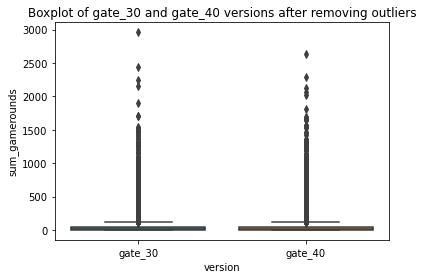

In [20]:
# Removing abnormal values
data2=data[data.sum_gamerounds < data.sum_gamerounds.max()]

# Making boxplot again after removing outliers
sns.boxplot(x='version',y='sum_gamerounds',data=data2)
plt.title('Boxplot of gate_30 and gate_40 versions after removing outliers')

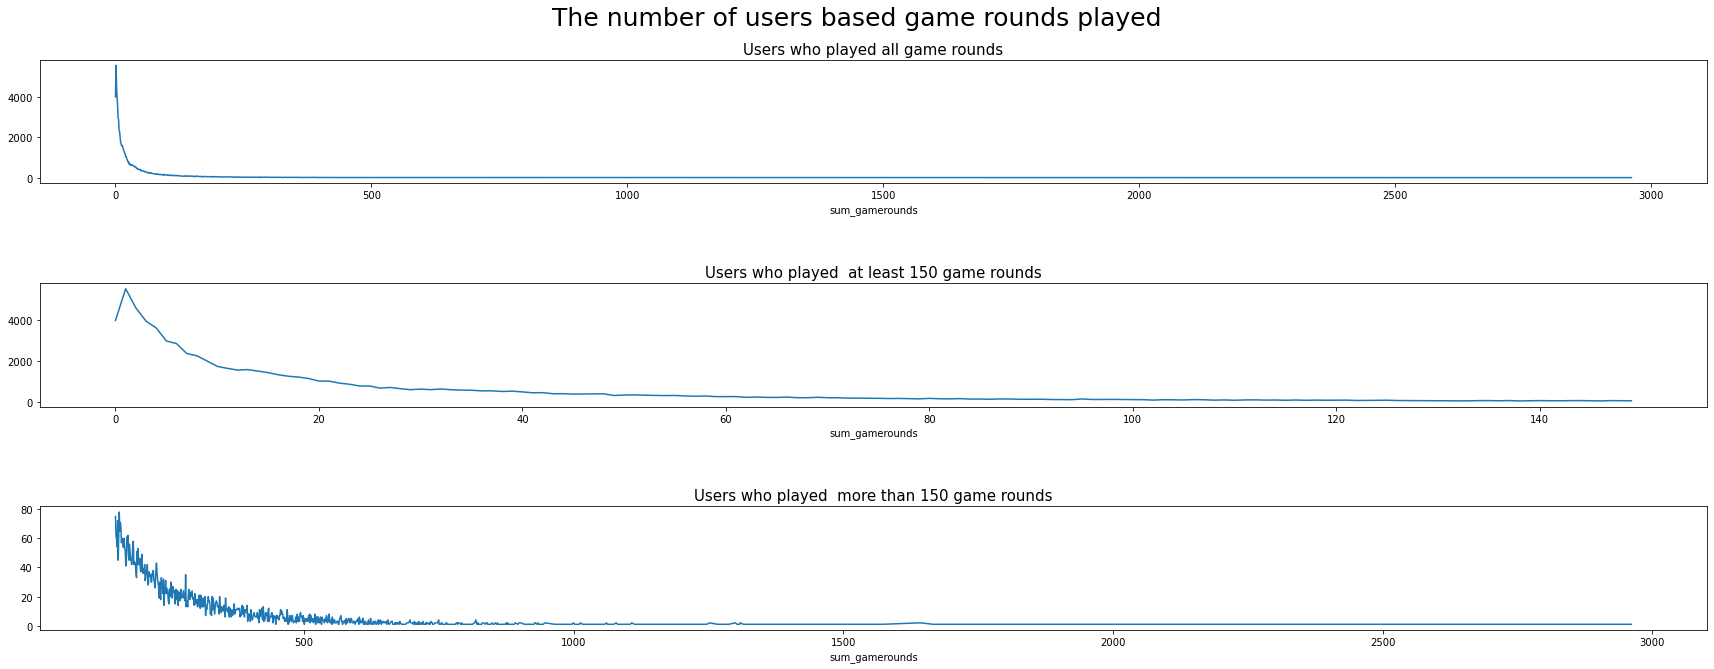

In [22]:
# Users based on rounds played
fig, axes = plt.subplots(3, 1, figsize = (25,10))
data2.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
data2.groupby("sum_gamerounds").userid.count()[:150].plot(ax = axes[1])
data2.groupby("sum_gamerounds").userid.count()[151:].plot(ax = axes[2])
plt.suptitle("The number of users based game rounds played", fontsize = 25)
axes[0].set_title("Users who played all game rounds", fontsize = 15)
axes[1].set_title("Users who played  at least 150 game rounds",fontsize=15)
axes[2].set_title("Users who played  more than 150 game rounds",fontsize=15)
plt.tight_layout(pad=5)

In [24]:
# Number of users who reached gate 30 and 40
data2.groupby('sum_gamerounds').userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

## Analyze Retention Details

Retention variables gives us player retention details.

1) retention_1 - did the player come back and play 1 day after installing?
2) retention_7 - did the player come back and play 7 days after installing?

In [25]:
pd.DataFrame({"1Day_count": data2["retention_1"].value_counts(),
              "7Day_count": data2["retention_7"].value_counts(),
              "1Day_ratio": data2["retention_1"].value_counts() / len(data2),
              "7Day_ratio": data2["retention_7"].value_counts() / len(data2)})

,1Day_count,7Day_count,1Day_ratio,7Day_ratio
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


Both the retention groups seem quite similar to each other.

In [26]:
# Summarize based on version and retention_1
data2.groupby(['version','retention_1']).sum_gamerounds.\
agg(['count','median','min','max','mean','std'])

count  median  min   max        mean  \
version retention_1 retention_7                                         
gate_30 False       False        22840       6    0   981   11.819746   
                    True          1825      43    0  1072   73.169315   
        True        False        13358      33    0   918   49.694490   
                    True          6676     127    0  2961  183.886309   
gate_40 False       False        23597       6    0   547   11.913294   
                    True          1773      47    0  1241   75.261139   
        True        False        13613      32    0  2640   50.025490   
                    True          6506     133    0  2294  190.282355   

                                        std  
version retention_1 retention_7              
gate_30 False       False         21.642643  
                    True          93.222330  
        True        False         58.125396  
                    True         189.626390  
gate_40 False       False         20.901020  
                    True          94.478048  
        True        False         60.924587  
                    True         194.220077

In [27]:
# Summarize based on version and retention_7
data2.groupby(['version','retention_7']).sum_gamerounds.\
agg(['count','median','min','max','mean','std'])

count  median  min   max        mean         std
version retention_7                                                  
gate_30 False        36198      11    0   981   25.796508   43.316158
        True          8501     105    0  2961  160.117516  179.358560
gate_40 False        37210      11    0  2640   25.856356   44.406112
        True          8279     111    0  2294  165.649837  183.792499

In [35]:
# Better suitable position of gate based on sample
data2.groupby('version').retention_1.mean(), data2.groupby('version').retention_7.mean()

(version
 gate_30    0.448198
 gate_40    0.442283
 Name: retention_1, dtype: float64,
 version
 gate_30    0.190183
 gate_40    0.182000
 Name: retention_7, dtype: float64)

## A/B Testing

### Assumptions
1) Normal Distribution
2) Homogeneity
3) Normality

In [32]:
# Define function for A/B Test
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "gate_30"][target]
    groupB = dataframe[dataframe[group] == "gate_40"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result from test
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "gate_30/gate_40 groups are similar!", "gate_30/gate_40 groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    return temp
    
        

In [33]:
# Apply A/B Testing
AB_Test(dataframe=data2, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



C:\Users\basil\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,gate_30/gate_40 groups are not similar!


The Shapiro test conducted above rejected our Null Hypothesis Ho for the normality assumption.Hence we had to conduct a Non-paramteric test such as Mann Whitney U test. By conducting this test we reject our Null Hypothesis Ho. This proves that there is a statistical difference between both the groups which consist of moving the gate from level 30 to level 40.